# Описание проекта
Вас пригласили на стажировку в отдел маркетинговой аналитики Яндекс.Афиши. Первое задание: помочь маркетологам снизить расходы — отказаться от невыгодных источников трафика и перераспределить бюджет.

Есть данные Яндекс.Афиши с июня 2017 по конец мая 2018 года:
- лог сервера с данными о посещениях сайта Яндекс.Афиши,
- выгрузка всех заказов за этот период,
- статистика рекламных расходов.

Вам предстоит изучить:
- как клиенты пользуются сервисом,
- когда делают первые покупки на сайте,
- сколько денег приносит компании каждый клиент,
- когда расходы на привлечение клиента окупаются.

Выручка измеряется в условных единицах — у.е.

Задачи:
1. Определить источники трафика, на которые маркетологам стоит делать упор. Объяснить свой выбор: на какие метрики ориентировался и почему;
2. Описать выводы, которые сделал после подсчёта метрик каждого вида: маркетинговых, продуктовых и метрик электронной коммерции;
3. Подвести итоги когортного анализа. Определить самые перспективные для компании когорты клиентов.

## Загрузите данные и подготовьте их к анализу

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from IPython.core.display import display, HTML

In [2]:
visits = pd.read_csv('/1/visits_log.csv')
orders = pd.read_csv('/1/orders_log.csv')
costs = pd.read_csv('/1/costs.csv')

In [3]:
display(HTML("<style>div.output_scroll { height: 170em; }</style>"))

def basic_info(data, title):
    print('')
    print(title)
    print('')
    print(data.info())
    print('')
    print(title)
    print('')
    print(data.describe())
    print('')
    print('Дубликаты')
    print(data.duplicated().sum())
    print('')
    print(title)
    print('')
    print(data.head(10))
    
basic_info(visits, 'Визиты')
basic_info(orders, 'Заказы')
basic_info(costs, 'Траты')


Визиты

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB
None

Визиты

           Source Id           Uid
count  359400.000000  3.594000e+05
mean        3.750515  9.202557e+18
std         1.917116  5.298433e+18
min         1.000000  1.186350e+13
25%         3.000000  4.613407e+18
50%         4.000000  9.227413e+18
75%         5.000000  1.372824e+19
max        10.000000  1.844668e+19

Дубликаты
0

Визиты

    Device               End Ts  Source Id             Start Ts  \
0    touch  2017-12-20 17:38:00          4  2017-12-20 17:20:00   
1  desktop  2018-02-19 17:21:00          2  2018-02-19

Визиты, заказы и траты:
- Переименуем столбцы;
- Переведём столбцы со временем в тип даты;
- Дубликатов нет.

In [4]:
visits.columns = ['device', 'date_end', 'source_id', 'date_start', 'uid']
visits['date_end'] = pd.to_datetime(visits['date_end'])
visits['date_start'] = pd.to_datetime(visits['date_start'])

orders.columns = ['date', 'revenue', 'uid']
orders['date'] = pd.to_datetime(orders['date'])

costs.columns = ['source_id', 'date', 'costs']
costs['date'] = pd.to_datetime(costs['date'])

In [5]:
visits['date_start'].min()

Timestamp('2017-06-01 00:01:00')

In [6]:
visits['date_start'].max()

Timestamp('2018-05-31 23:59:00')

In [7]:
visits['device'].unique()

array(['touch', 'desktop'], dtype=object)

In [8]:
visits['device'] = visits['device'].astype('category')

### Выводы:
- Данные приведены в нужный тип, дубликатов нет, столбцы названы корректно;
- Пользователи заходят на сайт через ПК или смартфон;
- Столбец с устройствами переведён в тип данных category;
- Данные действительно представлены за период с июня 2017 по май 2018.

## Рассчитайте метрики и постройте графики. Посчитайте метрики трёх видов:

### Продуктовые метрики

#### Рассчитайте DAU, WAU и MAU

- Вычислите средние значения этих метрик за весь период; 
- Отобразите изменения метрик во времени на графиках.

In [9]:
#Добавляем данные о времени в таблицу visits
visits['year']  = visits['date_start'].dt.year
visits['month'] = visits['date_start'].dt.month
visits['week']  = visits['date_start'].dt.week
visits['date'] = pd.to_datetime(visits['date_start'].dt.date)

<ipython-input-9-3a51f39bcbc0>:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  visits['week']  = visits['date_start'].dt.week


Средние значения метрики DAU за всё время: 908 
Средние значения метрики WAU за всё время: 5716 
Средние значения метрики MAU за всё время: 23228 


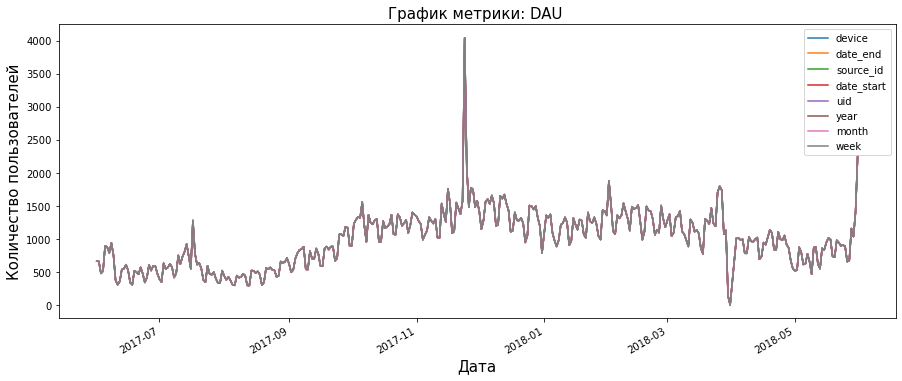

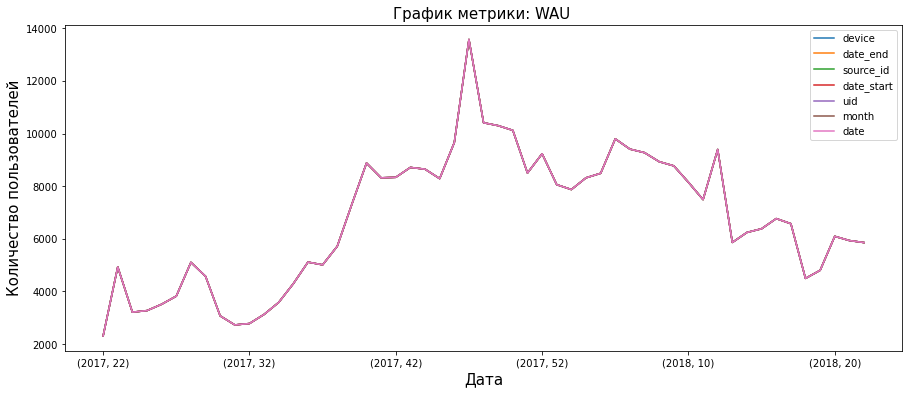

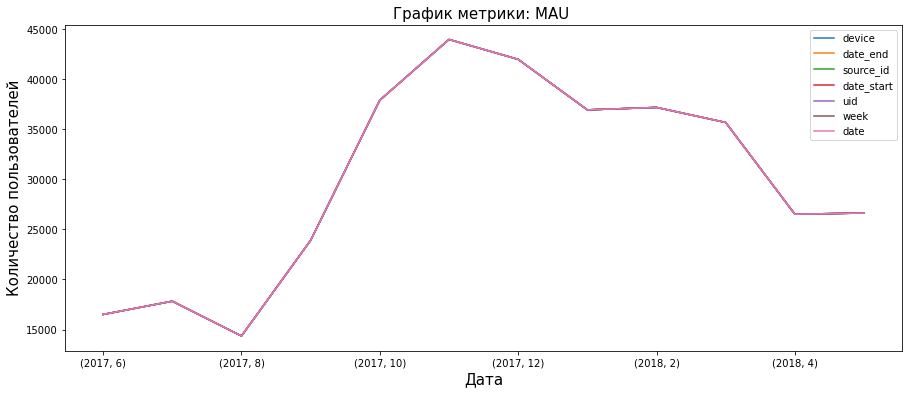

In [10]:
#display(HTML("<style>div.output_scroll { height: 95em; }</style>"))

def dwm(data, row, title):
    dwm_var = data.groupby(row).agg({'uid': 'nunique'})
    print("Средние значения метрики {} за всё время: {:.0f} ".format(title, dwm_var.uid.mean()))
    data.groupby(row).count().plot(style = '-', figsize = (15, 6));
    plt.title('График метрики: {} '.format(title), fontsize = 15);
    plt.xlabel('Дата', fontsize = 15);
    plt.ylabel('Количество пользователей', fontsize = 15);

# Выводим количество ежедневных активных пользователей    
dwm(visits, 'date', 'DAU')
# Выводим количество ежеднедельных активных пользователей
dwm(visits, ['year', 'week'], 'WAU')
# Выводим количество ежедмесячных активных пользователей
dwm(visits, ['year', 'month'], 'MAU')

##### Выводы:
Лучше всего данные описывает график по дням:
- В середине августа есть небольшой пик активности, после которого она ненадолго падает;
- После этого активность постепенно возрастает вплоть до октября, потом показатели более менее устойчивые;
- Мы видим локальный и самый крупный пик в новый год;
- После этого показатели активности постепенно уменьшаются до начала апреля, когда происходит резкий спад активности, она немного восстанавливается и продолжает падение.

- Средние значения метрики DAU за всё время: 908 
- Средние значения метрики WAU за всё время: 5716 
- Средние значения метрики MAU за всё время: 23228

Чётко выделяется сезонность: в тёплые месяцы показатели заметно ниже, это видно на всех графиках.

#### Определите, сколько раз за день пользователи в среднем заходят на сайт. 

- Постройте график, отражающий изменения метрики во времени;

In [11]:
# Групируем данные по уникальному id пользователя, считаем количество заходов на сайт
vistis_per_day = visits.groupby('date').agg({'uid': ['count','nunique']})
# Переименовываем столбцы
vistis_per_day.columns = ['count', 'unique_count']
# Вычисляем среднее количество заходов в день
vistis_per_day['mean'] = (vistis_per_day['count'] / vistis_per_day['unique_count']).round(3)
vistis_per_day['mean']

date
2017-06-01    1.098
2017-06-02    1.082
2017-06-03    1.072
2017-06-04    1.071
2017-06-05    1.089
              ...  
2018-05-27    1.084
2018-05-28    1.113
2018-05-29    1.092
2018-05-30    1.094
2018-05-31    1.130
Name: mean, Length: 364, dtype: float64

Среднее значение метрики VPD за всё время: 1.082  count    364.000000
mean       1.082168
std        0.020883
min        1.000000
25%        1.070000
50%        1.082500
75%        1.094000
max        1.218000
Name: mean, dtype: float64


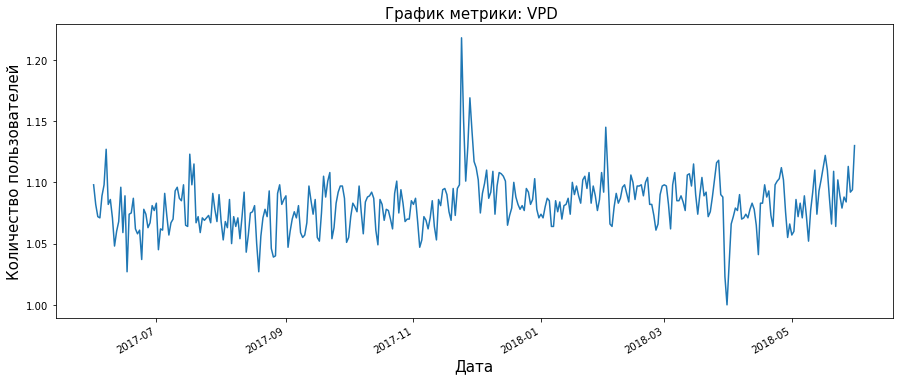

In [12]:
def vpd(data, title):
    print("Среднее значение метрики {} за всё время: {:.3f} ".format(title, data.mean()), data.describe())
    data.plot(style = '-', figsize = (15, 6));
    plt.title('График метрики: {} '.format(title), fontsize = 15);
    plt.xlabel('Дата', fontsize = 15);
    plt.ylabel('Количество пользователей', fontsize = 15);

    
vpd(vistis_per_day['mean'], 'VPD')

##### Выводы:

- В среднем на сайт заходят один раз в день, чуть больше 8% пользователей делают это больше раз;
- В новый год этот показатель увеличивается до 22%, в начале апреля просаживается до единицы.

#### Исследуйте, сколько времени пользователи проводят на сайте.

- Узнайте продолжительность типичной пользовательской сессии за весь период; 
- Чтобы выбрать подходящую среднюю меру, постройте график распределения.

Здесь полезно вспомнить, что у нас есть два устройства, с которых пользователи заходят на сайт - ПК и смартфон. Давайте посчитаем для них продолжительность сессии отдельно:

In [13]:
import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")

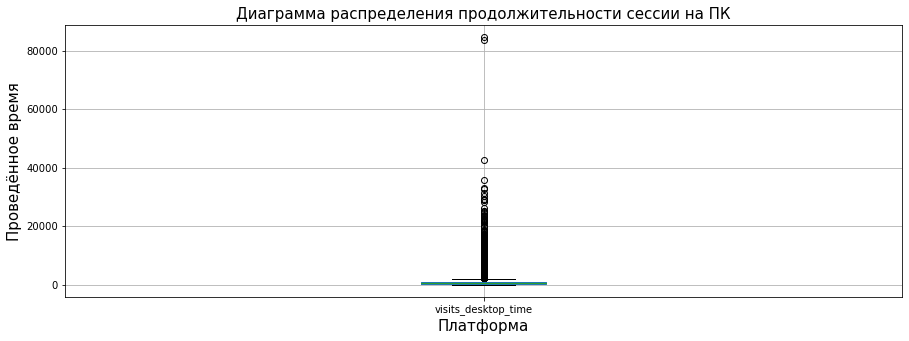

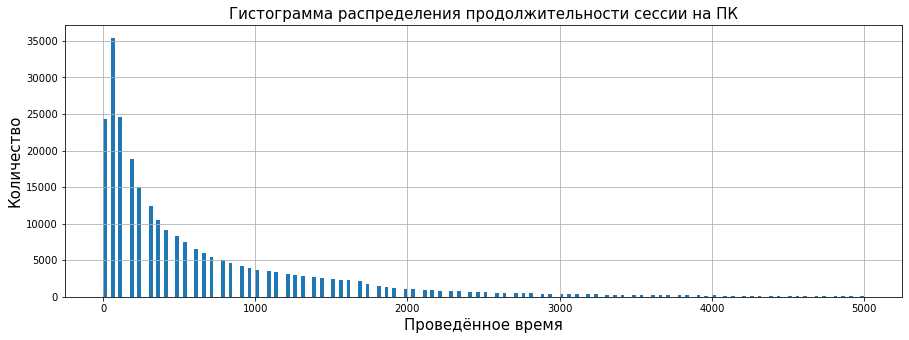

count    262567.000000
mean        703.946977
std        1091.545596
min           0.000000
25%         120.000000
50%         360.000000
75%         900.000000
max       84480.000000
Name: visits_desktop_time, dtype: float64
Средняя продолжительность пользовательской сессии на ПК: 11.732 минут
Медианная продолжительность пользовательской сессии на ПК: 6.000 минут


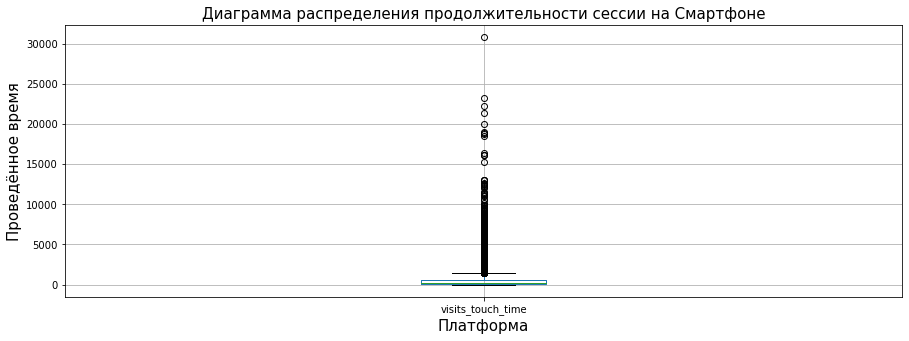

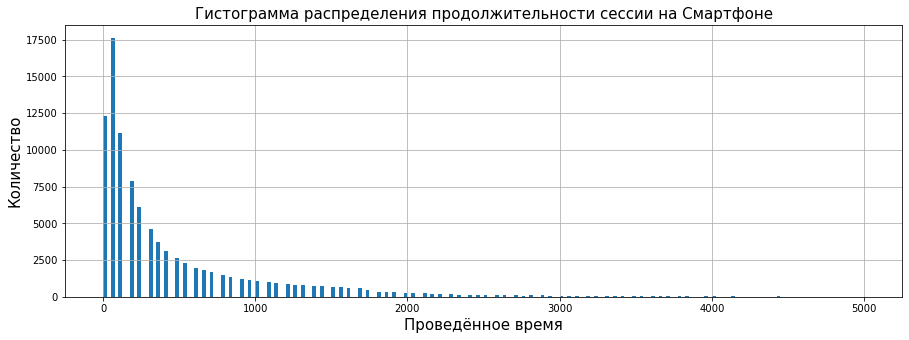

count    96833.000000
mean       479.619407
std        752.531533
min          0.000000
25%         60.000000
50%        180.000000
75%        600.000000
max      30840.000000
Name: visits_touch_time, dtype: float64
Средняя продолжительность пользовательской сессии на Смартфоне: 7.994 минут
Медианная продолжительность пользовательской сессии на Смартфоне: 3.000 минут


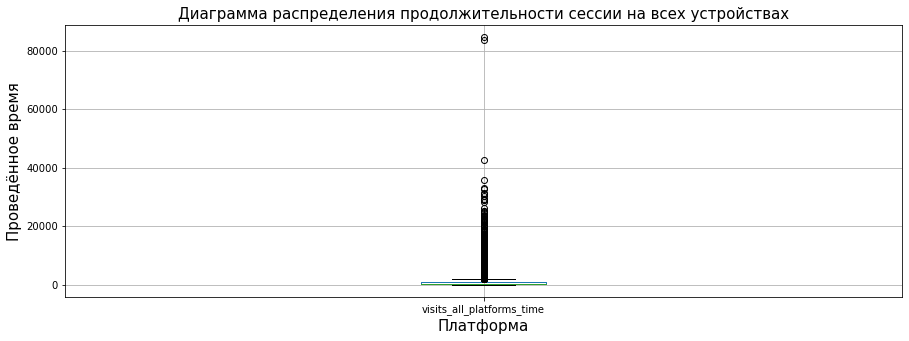

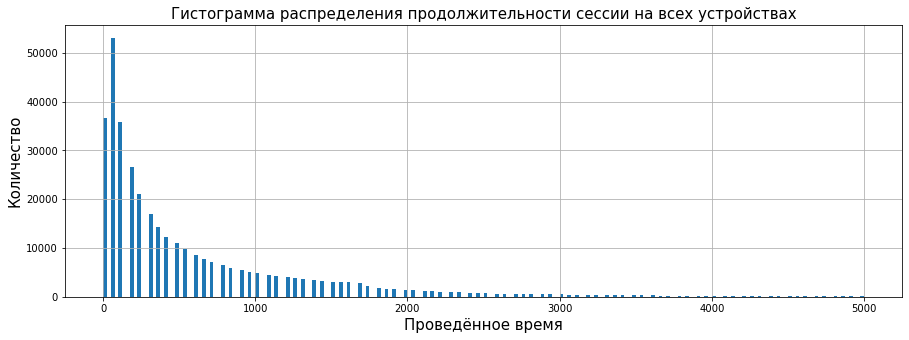

count    359400.000000
mean        643.506489
std        1016.334786
min           0.000000
25%         120.000000
50%         300.000000
75%         840.000000
max       84480.000000
Name: visits_all_platforms_time, dtype: float64
Средняя продолжительность пользовательской сессии на Всех устройствах: 10.725 минут
Медианная продолжительность пользовательской сессии на Всех устройствах: 5.000 минут


In [14]:
# Заводим отдельную переменную для визитов с ПК
visits_desktop = visits[(visits['device'] == 'desktop')]
# Считаем время сессии
visits_desktop['visits_desktop_time'] = (visits_desktop['date_end'] - visits_desktop['date_start']).dt.seconds

# Заводим отдельную переменную для визитов со Смартфона
visits_touch = visits[(visits['device'] == 'touch')]
# Считаем время сессии
visits_touch['visits_touch_time'] = (visits_touch['date_end'] - visits_touch['date_start']).dt.seconds

# Заводим отдельную переменную для визитов и с ПК, и со Смартфона
visits_all_platforms_time = visits[(visits['device'] == 'desktop') & (visits['device'] == 'touch')]
# Считаем время сессии
visits_all_platforms_time['visits_all_platforms_time'] = (visits['date_end'] - visits['date_start']).dt.seconds

def hists(data, column, title1, title2, name):
    plt.figure(figsize=(15,5))
    plt.title(title1, fontsize = 15)
    data.boxplot(column = column, figsize = (15,6));
    plt.ylabel('Проведённое время', fontsize = 15);
    plt.xlabel('Платформа', fontsize = 15);

    data.hist(column, bins=200, range = (0, 5000), figsize = (15, 5)) 
    plt.title(title2, fontsize = 15);
    plt.xlabel('Проведённое время', fontsize = 15);
    plt.ylabel('Количество', fontsize = 15);

    plt.show()
    
    print(data[column].describe())
    print("Средняя продолжительность пользовательской сессии на {}: {:.3f} минут"
      .format(name, data[column].mean() / 60))

    print("Медианная продолжительность пользовательской сессии на {}: {:.3f} минут"
      .format(name, data[column].median() / 60))
    
# Выводим графики для ПК    
hists(
    visits_desktop, 
    'visits_desktop_time', 
    'Диаграмма распределения продолжительности сессии на ПК', 
    'Гистограмма распределения продолжительности сессии на ПК',
    'ПК'
)

# Выводим графики для Смартфонов
hists(
    visits_touch, 
    'visits_touch_time', 
    'Диаграмма распределения продолжительности сессии на Смартфоне', 
    'Гистограмма распределения продолжительности сессии на Смартфоне',
    'Смартфоне'
)

# Выводим графики для ПК и Смартфонов
hists(
    visits_all_platforms_time, 
    'visits_all_platforms_time', 
    'Диаграмма распределения продолжительности сессии на всех устройствах', 
    'Гистограмма распределения продолжительности сессии на всех устройствах',
    'Всех устройствах'
)

##### Выводы:
- Очевидно наличие выбросов в данных для обоих устройств, при средней продолжительности в 8-10 минут встречаются значение в несколько часов;
- Логичнее ориентироваться на медианные значения, потому что распределение не является нормальным;
- На ПК сессия в среднем дольше, чем на смартфоне;
- Средняя продолжительность пользовательской сессии на ПК - 11.7 минут, медианная - 6 минут;
- Средняя продолжительность пользовательской сессии на смартфоне - 8 минут, медианная - 3 минут;
- Средняя продолжительность пользовательской сессии на всех устройствах - 10.7 минут, медианная - 5 минут;

#### Рассчитайте Retention Rate, применяя когортный анализ. 
- Покажите изменения метрики во времени на графике; 
- Найдите средний Retention Rate на второй месяц «жизни» когорт.

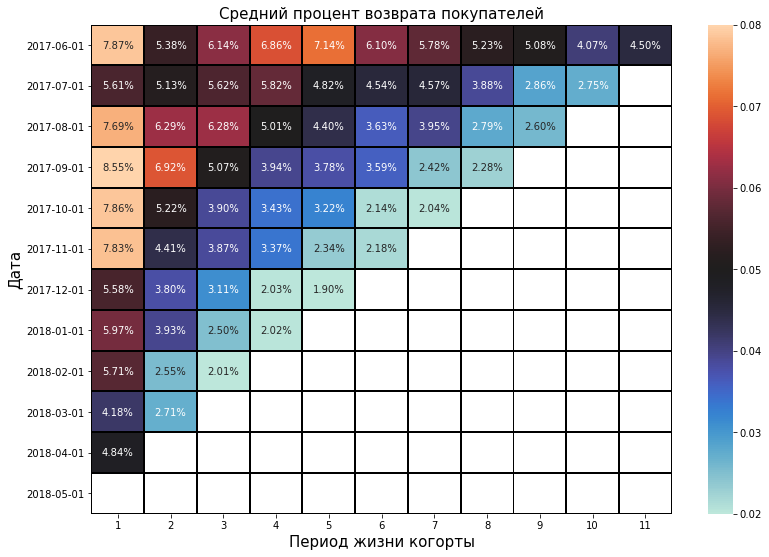

Среднее значение Ratention Rate для второй когорты: 6.52%


,1,2,3,4,5,6,7,8,9,10,11
first_activity_month,,,,,,,,,,,
2017-06-01,0.078664,0.053775,0.061392,0.068557,0.071423,0.061015,0.057772,0.052342,0.050833,0.040652,0.044951
2017-07-01,0.056088,0.051294,0.056164,0.058219,0.048174,0.045358,0.045738,0.038813,0.028615,0.027473,NaN
2017-08-01,0.076908,0.062862,0.062764,0.050093,0.044004,0.036342,0.039485,0.027895,0.026029,NaN,NaN
2017-09-01,0.085489,0.069205,0.050706,0.039392,0.037835,0.035860,0.024186,0.022809,NaN,NaN,NaN
2017-10-01,0.078608,0.052239,0.038958,0.034261,0.032221,0.021365,0.020364,NaN,NaN,NaN,NaN
2017-11-01,0.078281,0.044113,0.038682,0.033727,0.023415,0.021800,NaN,NaN,NaN,NaN,NaN
2017-12-01,0.055802,0.037993,0.031107,0.020263,0.019036,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,0.059715,0.039339,0.024973,0.020244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,0.057080,0.025454,0.020093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# Сперва сгруппируем данные по когорте first_order_month и месяцу совершения заказа month.
# Вычислим первый день, в который пользователь зашёл на сайт
first_activity_date = visits.groupby('uid')['date'].min()
# Переименуем датафрейм, в котором запишем полученные ранее данные
first_activity_date.name = 'first_activity_date'
# Объединим этот датафрейм с visits
visits = visits.join(first_activity_date, on='uid')

# Переведём данные в столбце в дату
visits['first_activity_date'] = pd.to_datetime(visits['first_activity_date'], unit='d')
# Вычислим из столбца с датой месяц, в который произошёл первый заход на сайт
visits['first_activity_month'] = visits['first_activity_date'].astype('datetime64[M]')
# Вычислим из столбца с датой месяц, в который пользователь зашёл на сайт
visits['month'] = visits['date'].astype('datetime64[M]')



# Узнаем, в какую кагорту добавлять пользователя. Для этого вычтем из месяца, 
#в который пользователь зашёл на сайт месяц, в который он впервые зашёл на сайт
visits['cohort_lifetime'] = visits['month'] - visits['first_activity_month']
# Вычленим номер месяца из разницы между двумя датами
visits['cohort_lifetime'] = visits[
    'cohort_lifetime'
] / np.timedelta64(1, 'M')
# Округлим полученные значения, приведём их к целочисленному типу
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype(
    'int'
) 
# Получили целое число месяцев, обозначающее порядковый месяц совершения захода на сайт относительно месяца первого захода

# Оставим в данных только упоминание о дне, месяце и годе
#visits['first_activity_month'] = visits['first_activity_month'].dt.strftime('%d.%m.%Y')

# Создадим датафрейм cohorts, в котором сгруппируем данные по когорте и месяцу совершения заказа 
cohorts = visits.groupby(['first_activity_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()
# Найдём количество пользователей в первой когорте, оставим данные об id пользователя и дате первого захода на сайт
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][
    ['first_activity_month', 'uid']
]
# Переименуем столбец, в котором хранятся id пользователей
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})
# Объединим этот датафрейм с cohorts
cohorts = cohorts.merge(initial_users_count,on='first_activity_month')
# Рассчитаем Retention Rate. Разделим количество активных пользователей на исходное число пользователей в когорте
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']
# Построим сводную таблицу
retention_pivot = cohorts.pivot_table(
    index='first_activity_month',
    columns='cohort_lifetime',
    values='retention',
    aggfunc='sum',
)

retention_pivot.columns = ['0','1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11']
del retention_pivot['0']

# Создадим тепловую карту
plt.figure(figsize=(13, 9))
plt.title('Средний процент возврата покупателей', fontsize = 15)
sns.heatmap(retention_pivot, annot=True, fmt='.2%', linewidths=1, linecolor='black', 
             xticklabels= retention_pivot.columns,yticklabels= retention_pivot.index.strftime('%Y-%m-%d'),
             vmin=0.02, vmax=0.08, center= 0.05)
plt.xlabel('Период жизни когорты', fontsize = 15);
plt.ylabel('Дата', fontsize = 15);
plt.show()

# Вычислим среднее значение Ratention Rate для второй когорты
print('Среднее значение Ratention Rate для второй когорты: {:.2%}'.format(retention_pivot['1'].mean()))

retention_pivot


##### Выводы:
- Среднее значение Ratention Rate для второй когорты 6.52%;
- После первого визита возвращаются на сайт от 2 до 8-9% пользователей;
- При приближении к лету возвращаемость снижается по всем когортам;
- Пользователи возвращаются и через год, но показатели явно идут на убыль;
- В целом наблюдаются довольно слабые показатели по возвратам.

#### Общие выводы по шагу:

- Данные приведены в нужный тип, дубликатов нет, столбцы названы корректно;
- Пользователи заходят на сайт через ПК или смартфон;
- Столбец с устройствами переведён в тип данных category;
- Данные действительно представлены за период с июня 2017 по май 2018.
- Мы видим локальный и самый крупный пик активности в новый год;
- Чётко выделяется сезонность: в тёплые месяцы показатели активности пользователей заметно ниже;
- В среднем на сайт заходят один раз в день, чуть больше 8% пользователей делают это больше раз;
- В новый год этот показатель увеличивается до 22%, в начале апреля просаживается до единицы;
- Средняя продолжительность пользовательской сессии на ПК - 11.7 минут, медианная - 6 минут;
- Средняя продолжительность пользовательской сессии на смартфоне - 8 минут, медианная - 3 минут;
- Средняя продолжительность пользовательской сессии на всех устройствах - 10.7 минут, медианная - 5 минут;
- Среднее значение Ratention Rate для второй когорты 6.52%;
- После первого визита возвращаются на сайт от 2 до 8-9% пользователей;
- При приближении к лету возвращаемость снижается по всем когортам;
- Пользователи возвращаются и через год, но показатели явно идут на убыль;
- В целом наблюдаются довольно слабые показатели по возвратам.

### Метрики электронной коммерции

#### Исследуйте, сколько времени в среднем проходит с момента первого посещения сайта до совершения покупки. 

Подготавливаем данные:

In [16]:
first_orders_date = orders.groupby('uid')['date'].min()
first_orders_date.name = 'first_orders_date'
orders = orders.join(first_activity_date, on='uid')
orders = orders.merge(first_orders_date, on='uid')

orders['first_activity_date'] = pd.to_datetime(orders['first_activity_date'])
orders['first_orders_month'] = orders['date'].astype('datetime64[M]')
orders['month'] = orders['first_orders_date'].astype('datetime64[M]')

orders['orders_cohort_lifetime'] = orders['first_orders_month'] - orders['month']
orders['orders_cohort_lifetime'] = orders[
    'orders_cohort_lifetime'
] / np.timedelta64(1, 'M')
orders['orders_cohort_lifetime'] = orders['orders_cohort_lifetime'].round().astype(
    'int'
) 

orders['passed_days'] = (
    (orders['first_orders_date'] - orders['first_activity_date']) /
    np.timedelta64(1,'D')
).astype('int')

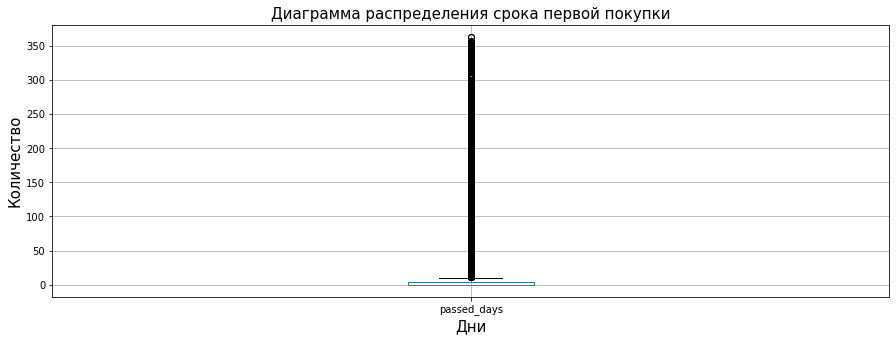

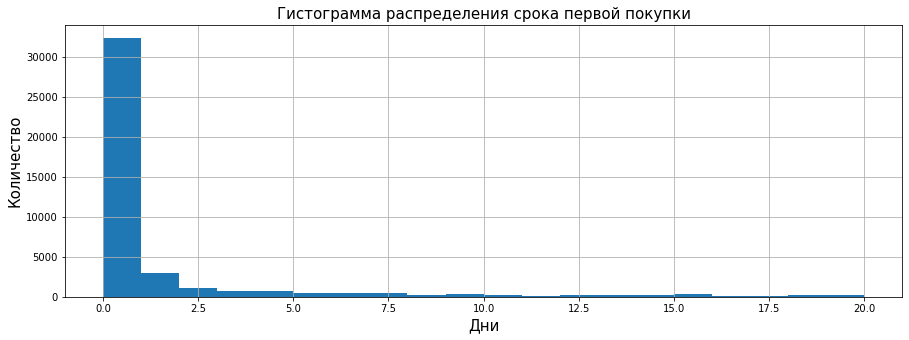

count    50415.000000
mean        17.611227
std         46.469172
min          0.000000
25%          0.000000
50%          0.000000
75%          4.000000
max        363.000000
Name: passed_days, dtype: float64
Средняя продолжительность до первой покупки: 18 дней
Медианная продолжительность до первой покупки: 0 дней


In [17]:
def hists(data, column, title1, title2):
    plt.figure(figsize=(15,5))
    plt.title(title1, fontsize = 15)
    data.boxplot(column = column, figsize = (15,6));
    plt.ylabel('Количество', fontsize = 15);
    plt.xlabel('Дни', fontsize = 15);

    data.hist(column, bins=20, range = (0, 20), figsize = (15, 5)) 
    plt.title(title2, fontsize = 15);
    plt.xlabel('Дни', fontsize = 15);
    plt.ylabel('Количество', fontsize = 15);

    plt.show()
    
    print(data[column].describe())
    print("Средняя продолжительность до первой покупки: {:.0f} дней"
      .format(data[column].mean()))

    print("Медианная продолжительность до первой покупки: {:.0f} дней"
      .format(data[column].median()))
    
hists(
    orders, 
    'passed_days', 
    'Диаграмма распределения срока первой покупки', 
    'Гистограмма распределения срока первой покупки'
)

##### Выводы:
- Большинство людей производят покупку в течении первых 4-х дней (75%), в половине случаев это происходит в первый день;
- Из-за выбросов среднее значение - 18 дней.

#### Рассчитайте среднее количество покупок на одного покупателя за 6 месяцев. 

Убираем из выборки месяц, в котором есть всего один визит

In [18]:
orders = orders[orders['date'] < '2018-06-01']

Считаем количество покупателей и количество покупок

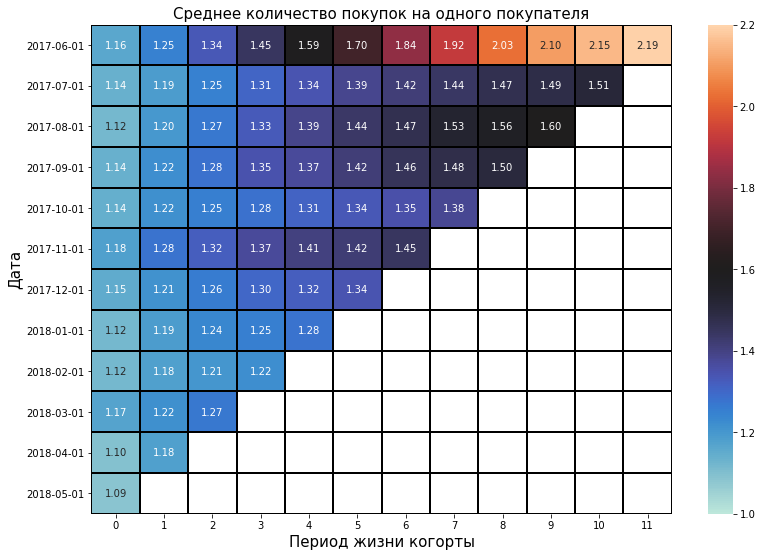

Среднее количество покупок на одного покупателя за 6 месяцев: 1.43
Среднее количество покупок на одного покупателя за всё время: 2.19


In [19]:
customers_count = (orders.groupby(['month'])
    .agg({'uid':'nunique'})
    .rename(columns={'uid':'customers_count'})
    .reset_index()
    )

orders_count = (orders.groupby(['month','orders_cohort_lifetime'])
    .agg({'revenue': 'count'})
    .rename(columns={'revenue':'orders_count'})
    .reset_index()
    )

customers_orders_count = customers_count.merge(orders_count, on = 'month')
customers_orders_count['difference'] = (customers_orders_count['orders_count'] / customers_orders_count['customers_count'])    


orders_pivot = customers_orders_count.pivot_table(
    index='month',
    columns='orders_cohort_lifetime',
    values='difference',
    aggfunc='sum',
).cumsum(axis=1)

plt.figure(figsize=(13, 9))
plt.title('Среднее количество покупок на одного покупателя', fontsize = 15)
sns.heatmap(orders_pivot, annot=True, fmt='.2f', linewidths=1, linecolor='black',
           xticklabels= orders_pivot.columns,yticklabels= orders_pivot.index.strftime('%Y-%m-%d'),
           vmin=1, vmax=2.2, center = 1.6)
plt.xlabel('Период жизни когорты', fontsize = 15);
plt.ylabel('Дата', fontsize = 15);
plt.show()

print('Среднее количество покупок на одного покупателя за 6 месяцев: {:.2f}'.format(orders_pivot[5].mean()))
print('Среднее количество покупок на одного покупателя за всё время: {:.2f}'.format(orders_pivot[11].mean()))

##### Выводы:
- Среднее количество покупок на одного покупателя за 6 месяцев: 1.43;
- Среднее количество покупок на одного покупателя за всё время: 2.19;
- Можно сделать вывод, что покупатели довольно редко делают повторную покупку, а если и делают, то только единожды. Нужно поработать над тем, чтобы стимулировать пользователей на повторные покупки.

#### Рассчитайте средний чек, применяя группировку по времени совершения покупки.

In [20]:
avg_revenue = orders.groupby('uid').agg({'revenue': 'sum'})

avg_revenue_per_day = orders.groupby('date').agg({'uid': 'nunique','revenue': 'sum'})
avg_revenue_per_day.columns = ['unique_users', 'sum']
avg_revenue_per_day['mean'] = (avg_revenue_per_day ['sum'] / avg_revenue_per_day ['unique_users']).round(3)
avg_revenue_per_day.describe()

,unique_users,sum,mean
count,45990.000000,45990.000000,45990.000000
mean,1.096195,5.480621,4.993245
std,0.339235,22.923073,22.162704
min,1.000000,0.000000,0.000000
25%,1.000000,1.400000,1.340000
50%,1.000000,2.815000,2.690000
75%,1.000000,5.500000,4.890000
max,9.000000,2633.280000,2633.280000


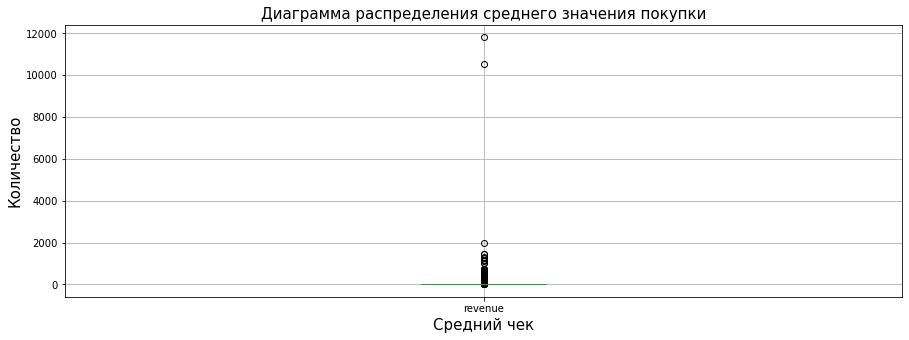

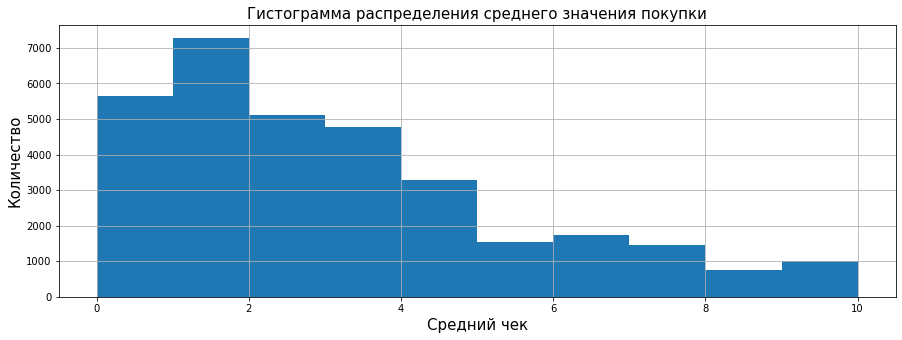

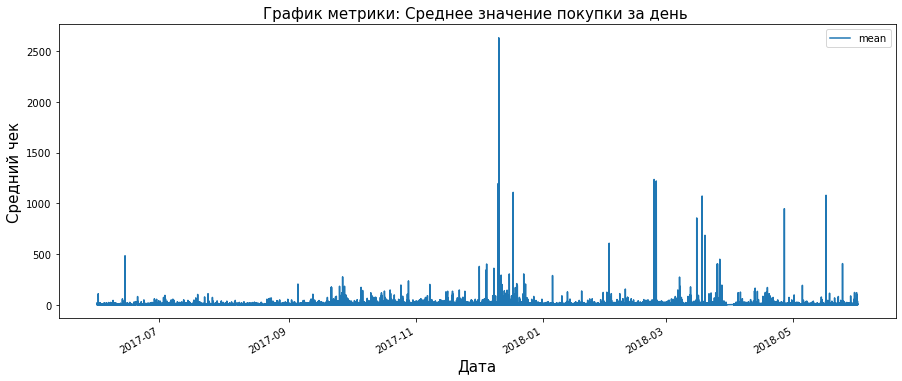

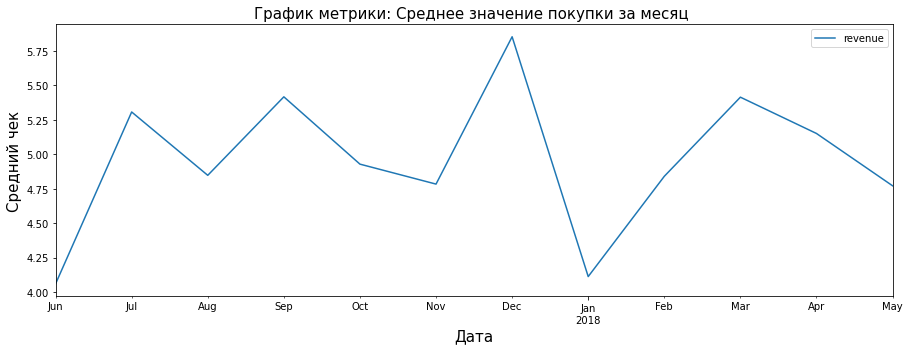

Среднее значение покупки у.е count    36522.000000
mean         6.901423
std         88.129739
min          0.000000
25%          1.470000
50%          3.050000
75%          5.800000
max      11810.180000
Name: revenue, dtype: float64
Среднее значение покупки: 7 у.е
Медианное значение покупки: 3 у.е


In [21]:
def hists(data, data2, column, title1, title2, title3, title4):
    plt.figure(figsize=(15,5))
    plt.title(title1, fontsize = 15)
    data.boxplot(column = column, figsize = (15,6));
    plt.ylabel('Количество', fontsize = 15);
    plt.xlabel('Средний чек', fontsize = 15);

    data.hist(column, bins=10, range = (0, 10), figsize = (15, 5)) 
    plt.title(title2, fontsize = 15);
    plt.xlabel('Средний чек', fontsize = 15);
    plt.ylabel('Количество', fontsize = 15);

    data2.plot(y = 'mean', figsize = (15, 6));
    plt.title('График метрики: {} '.format(title3), fontsize = 15);
    plt.xlabel('Дата', fontsize = 15);
    plt.ylabel('Средний чек', fontsize = 15);

    orders.groupby(orders['first_orders_month']).agg({column: 'mean'}).plot(figsize=(15, 5))
    plt.title('График метрики: {} '.format(title4), fontsize = 15);
    plt.xlabel('Дата', fontsize = 15);
    plt.ylabel('Средний чек', fontsize = 15);
    
    plt.show()
    
    print('Среднее значение покупки у.е', data[column].describe())
    print("Среднее значение покупки: {:.0f} у.е".format(data[column].mean()))
    print("Медианное значение покупки: {:.0f} у.е".format(data[column].median()))

hists(
    avg_revenue,
    avg_revenue_per_day,
    'revenue', 
    'Диаграмма распределения среднего значения покупки', 
    'Гистограмма распределения среднего значения покупки',
    'Среднее значение покупки за день',
    'Среднее значение покупки за месяц'
)

##### Выводы:
- В данном случае лучше ориентироваться по медианному значению, потому что в выборке имеются выбросы;
- Средний чек на одного пользователя составляет 3 у.е.
- На графике распределения значений среднего чека по времени виден самый большой пик зимой ближе к Новому году, так же есть несколько меньших пиков весной, летом их уже не видно.

#### Выясните, как меняется LTV на покупателя по когортам. Рассчитайте средний LTV по когортам за 6 месяцев

In [22]:
# Из датафрейма orders выделяю столбцы месяца первого захода, номер кагорты и общие доходы с неё. 
# Создаю столбец с порядковым номером каждой строки, это понадобится дальше для объединения датафреймов.
orders_ltv = orders.groupby(['month', 'orders_cohort_lifetime'], as_index=False).agg({'revenue': 'sum'})
orders_ltv

,month,orders_cohort_lifetime,revenue
0,2017-06-01,0,9557.49
1,2017-06-01,1,981.82
2,2017-06-01,2,885.34
3,2017-06-01,3,1931.30
4,2017-06-01,4,2068.58
...,...,...,...
73,2018-03-01,1,1063.05
74,2018-03-01,2,1114.87
75,2018-04-01,0,10600.69
76,2018-04-01,1,1209.92


In [23]:
# Объединяю датафрейм с количеством пользователей и предыдущий датафрейм
ltv_data = pd.merge(customers_count, orders_ltv, on='month')
ltv_data

,month,customers_count,orders_cohort_lifetime,revenue
0,2017-06-01,2023,0,9557.49
1,2017-06-01,2023,1,981.82
2,2017-06-01,2023,2,885.34
3,2017-06-01,2023,3,1931.30
4,2017-06-01,2023,4,2068.58
...,...,...,...,...
73,2018-03-01,3533,1,1063.05
74,2018-03-01,3533,2,1114.87
75,2018-04-01,2276,0,10600.69
76,2018-04-01,2276,1,1209.92


In [24]:
# Считаю Ltv, деля доход на количество пользователей
ltv_data['ltv'] = (ltv_data['revenue'] / ltv_data['customers_count'])
ltv_data.describe()

,customers_count,orders_cohort_lifetime,revenue,ltv
count,78.000000,78.000000,78.000000,78.000000
mean,2840.397436,3.666667,3231.458718,1.120532
std,1073.217015,2.943920,5415.222904,1.709486
min,1370.000000,0.000000,211.480000,0.053879
25%,1923.000000,1.000000,505.760000,0.184999
50%,2581.000000,3.000000,1021.160000,0.375126
75%,4081.000000,6.000000,1894.767500,0.727028
max,4383.000000,11.000000,21716.200000,6.010218


In [25]:
ltv_data

,month,customers_count,orders_cohort_lifetime,revenue,ltv
0,2017-06-01,2023,0,9557.49,4.724414
1,2017-06-01,2023,1,981.82,0.485329
2,2017-06-01,2023,2,885.34,0.437637
3,2017-06-01,2023,3,1931.30,0.954671
4,2017-06-01,2023,4,2068.58,1.022531
...,...,...,...,...,...
73,2018-03-01,3533,1,1063.05,0.300892
74,2018-03-01,3533,2,1114.87,0.315559
75,2018-04-01,2276,0,10600.69,4.657597
76,2018-04-01,2276,1,1209.92,0.531599


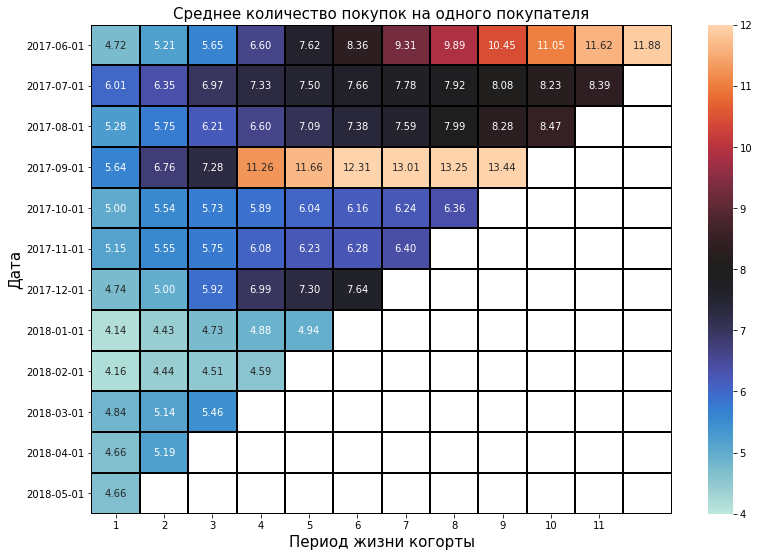

Средний LTV по когортам за 6 месяцев: 7.97 у.е
Средний LTV по когортам за всё время: 11.88 у.е


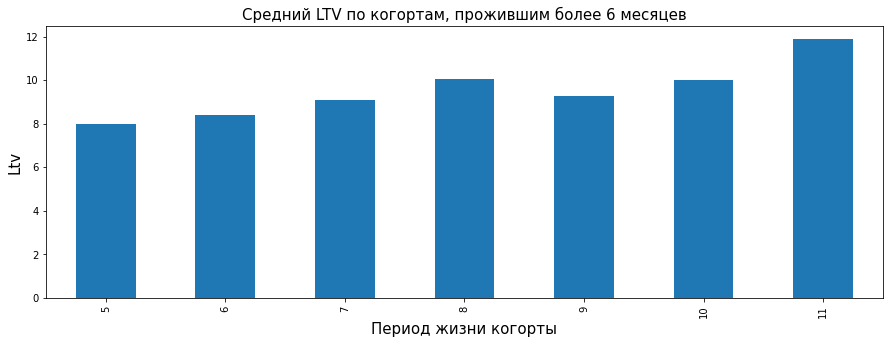

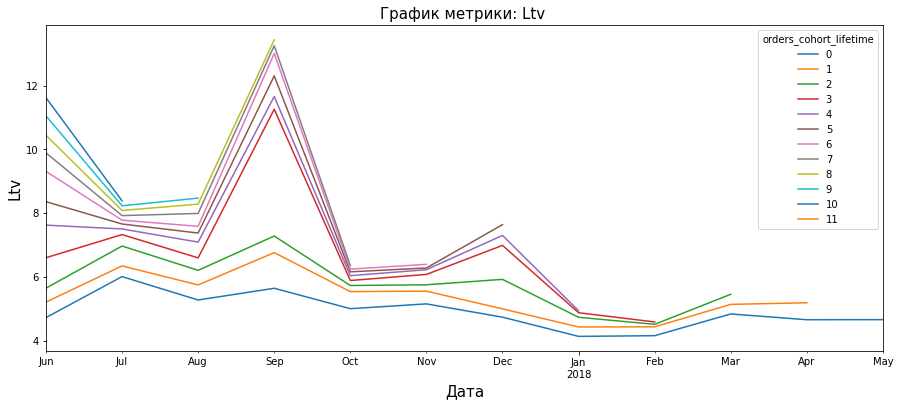

orders_cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
month,,,,,,,,,,,,
2017-06-01,4.724414,5.209743,5.647380,6.602051,7.624582,8.360084,9.310524,9.892116,10.445329,11.051117,11.622378,11.879234
2017-07-01,6.010218,6.345429,6.968960,7.327936,7.504727,7.660775,7.780983,7.922803,8.084035,8.231180,8.386854,NaN
2017-08-01,5.276518,5.748511,6.206993,6.598270,7.092321,7.375861,7.586526,7.991533,8.283745,8.471723,NaN,NaN
2017-09-01,5.644529,6.762115,7.283045,11.258838,11.659396,12.306463,13.008071,13.251220,13.435227,NaN,NaN,NaN
2017-10-01,5.003733,5.539495,5.730889,5.888035,6.039594,6.159956,6.244772,6.360242,NaN,NaN,NaN,NaN
2017-11-01,5.154683,5.553916,5.753472,6.078424,6.226437,6.280316,6.395244,NaN,NaN,NaN,NaN,NaN
2017-12-01,4.738191,4.998565,5.923662,6.988937,7.301866,7.639913,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,4.135636,4.430394,4.734675,4.877453,4.940151,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,4.156987,4.435262,4.513777,4.587921,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
# Строю графики
orders_ltv_pivot = ltv_data.pivot_table(
    index='month',
    columns='orders_cohort_lifetime',
    values='ltv',
    aggfunc='sum',
).cumsum(axis=1)

plt.figure(figsize=(13, 9))
plt.title('Среднее количество покупок на одного покупателя', fontsize = 15)
sns.heatmap(orders_ltv_pivot, annot=True, fmt='.2f', linewidths=1, linecolor='black', 
             xticklabels= retention_pivot.columns,yticklabels= retention_pivot.index.strftime('%Y-%m-%d'),
             vmin=4, vmax=12, center= 8)
plt.xlabel('Период жизни когорты', fontsize = 15);
plt.ylabel('Дата', fontsize = 15);
plt.show()

print('Средний LTV по когортам за 6 месяцев: {:.2f} у.е'.format(orders_ltv_pivot[5].mean()))
print('Средний LTV по когортам за всё время: {:.2f} у.е'.format(orders_ltv_pivot[11].mean()))

orders_ltv_pivot.mean().loc[5:].plot(kind='bar', figsize = (15, 5)) 
plt.title('Средний LTV по когортам, прожившим более 6 месяцев', fontsize = 15);
plt.xlabel('Период жизни когорты', fontsize = 15);
plt.ylabel('Ltv', fontsize = 15);
plt.show()

orders_ltv_pivot.plot(figsize = (15, 6));
plt.title('График метрики: {} '.format('Ltv'), fontsize = 15);
plt.xlabel('Дата', fontsize = 15);
plt.ylabel('Ltv', fontsize = 15);
plt.show()

orders_ltv_pivot

##### Выводы:
- Люди, которые впервые пришли в августе, принесли больше всего денег, особенно хорошо это проявляется ближе к Новому Году;
- Средний LTV по когортам за 6 месяцев: 7.97 у.е
- Средний LTV по когортам за всё время: 11.88 у.е
- Когорты, прожившие более 6 месяцев, приносят от 6 у.е до 13.5 у.е;

#### Общие выводы:

- Большинство людей производят покупку в течении первых 4-х дней (75%), в половине случаев это происходит в первый день;
- Среднее количество покупок на одного покупателя за 6 месяцев: 1.43;
- Среднее количество покупок на одного покупателя за всё время: 2.19;
- Можно сделать вывод, что покупатели довольно редко делают повторную покупку, а если и делают, то только единожды. Нужно поработать над тем, чтобы стимулировать пользователей на повторные покупки.
- Средний чек на одного пользователя составляет 3 у.е;
- На графике распределения значений среднего чека по времени виден самый большой пик зимой ближе к Новому году, так же есть несколько меньших пиков весной, летом их уже не видно.
- Люди, которые впервые пришли в августе, принесли больше всего денег, особенно хорошо это проявляется ближе к Новому Году;
- Средний LTV по когортам за 6 месяцев: 7.97 у.е
- Средний LTV по когортам за всё время: 11.88 у.е
- Когорты, прожившие более 6 месяцев, приносят от 6 у.е до 13.5 у.е;

### Маркетинговые метрики

#### Посчитайте общую сумму расходов на маркетинг.  Выясните, как траты распределены по источникам. 


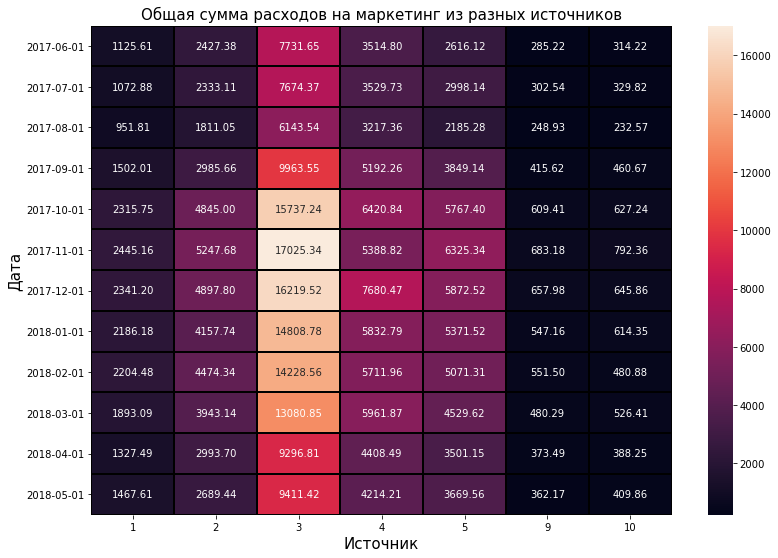

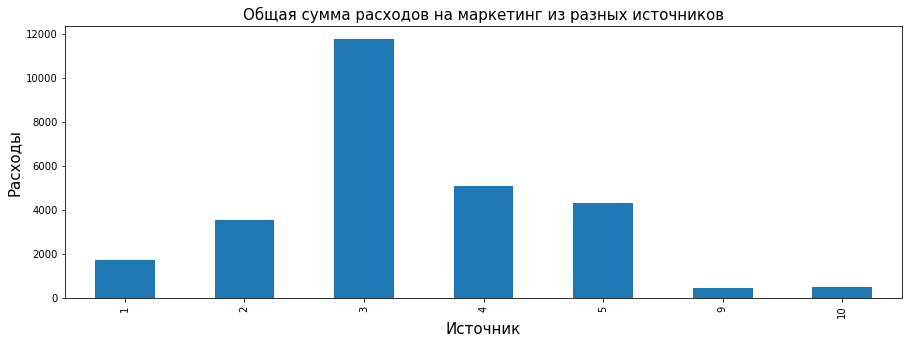

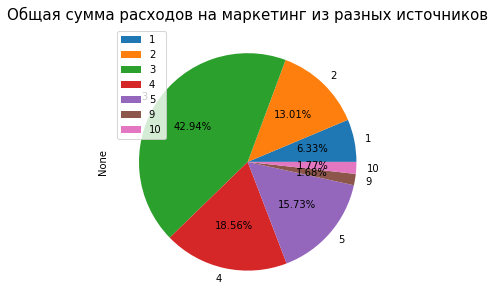

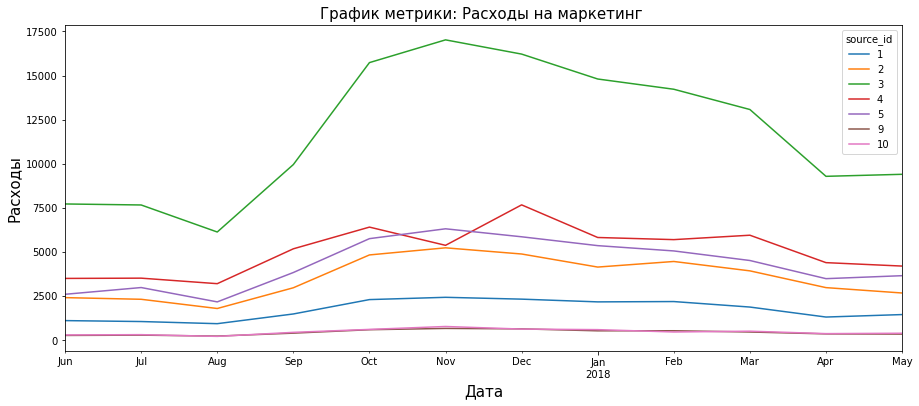

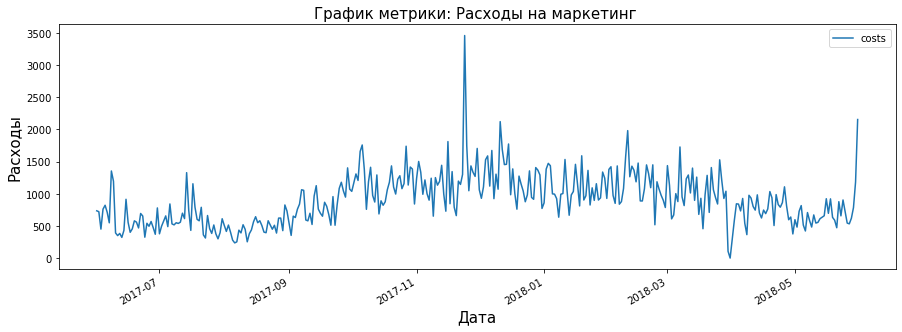

Общая сумма расходов на маркетинг из 1 источника: 20833.27 у.е
Средняя сумма расходов на маркетинг из 1 источника: 1736.11 у.е
Общая сумма расходов на маркетинг из 2 источника: 42806.04 у.е
Средняя сумма расходов на маркетинг из 2 источника: 3567.17 у.е
Общая сумма расходов на маркетинг из 3 источника: 141321.63 у.е
Средняя сумма расходов на маркетинг из 3 источника: 11776.80 у.е
Общая сумма расходов на маркетинг из 4 источника: 61073.60 у.е
Средняя сумма расходов на маркетинг из 4 источника: 5089.47 у.е
Общая сумма расходов на маркетинг из 5 источника: 51757.10 у.е
Средняя сумма расходов на маркетинг из 5 источника: 4313.09 у.е
Общая сумма расходов на маркетинг из 9 источника: 5517.49 у.е
Средняя сумма расходов на маркетинг из 9 источника: 459.79 у.е
Общая сумма расходов на маркетинг из 10 источника: 5822.49 у.е
Средняя сумма расходов на маркетинг из 10 источника: 485.21 у.е


source_id,1,2,3,4,5,9,10
month,,,,,,,
2017-06-01,1125.61,2427.38,7731.65,3514.80,2616.12,285.22,314.22
2017-07-01,1072.88,2333.11,7674.37,3529.73,2998.14,302.54,329.82
2017-08-01,951.81,1811.05,6143.54,3217.36,2185.28,248.93,232.57
2017-09-01,1502.01,2985.66,9963.55,5192.26,3849.14,415.62,460.67
2017-10-01,2315.75,4845.00,15737.24,6420.84,5767.40,609.41,627.24
2017-11-01,2445.16,5247.68,17025.34,5388.82,6325.34,683.18,792.36
2017-12-01,2341.20,4897.80,16219.52,7680.47,5872.52,657.98,645.86
2018-01-01,2186.18,4157.74,14808.78,5832.79,5371.52,547.16,614.35
2018-02-01,2204.48,4474.34,14228.56,5711.96,5071.31,551.50,480.88


In [27]:
costs['month'] = costs['date'].astype('datetime64[M]')
costs_cohort = costs.groupby(['month', 'source_id']).agg({'costs': 'sum'})

pivot_costs_cohort = costs_cohort.pivot_table(
    index='month',
    columns='source_id',
    values='costs',
    aggfunc='sum'
) 
pivot_costs_cohort

plt.figure(figsize=(13, 9))
plt.title('Общая сумма расходов на маркетинг из разных источников', fontsize = 15)
sns.heatmap(pivot_costs_cohort , annot=True, fmt='.2f', linewidths=1, linecolor='black', 
             xticklabels= pivot_costs_cohort.columns,yticklabels= pivot_costs_cohort.index.strftime('%Y-%m-%d'))
plt.xlabel('Источник', fontsize = 15);
plt.ylabel('Дата', fontsize = 15);
plt.show()

pivot_costs_cohort.mean().plot(kind='bar', figsize = (15, 5)) 
plt.title('Общая сумма расходов на маркетинг из разных источников', fontsize = 15);
plt.xlabel('Источник', fontsize = 15);
plt.ylabel('Расходы', fontsize = 15);
plt.show()

pivot_costs_cohort.mean().plot(kind='pie', figsize = (15, 5), autopct='%1.2f%%', legend=True) 
plt.title('Общая сумма расходов на маркетинг из разных источников', fontsize = 15);
plt.show()

pivot_costs_cohort.plot(figsize = (15, 6));
plt.title('График метрики: {} '.format('Расходы на маркетинг'), fontsize = 15);
plt.xlabel('Дата', fontsize = 15);
plt.ylabel('Расходы', fontsize = 15);
plt.show()

costs.groupby(costs['date']).agg({'costs': 'sum'}).plot(figsize=(15, 5))
plt.title('График метрики: {} '.format('Расходы на маркетинг'), fontsize = 15);
plt.xlabel('Дата', fontsize = 15);
plt.ylabel('Расходы', fontsize = 15);
plt.show()

for i in pivot_costs_cohort:
    print('Общая сумма расходов на маркетинг из {} источника: {:.2f} у.е'.format(i, pivot_costs_cohort[i].sum()))
    print('Средняя сумма расходов на маркетинг из {} источника: {:.2f} у.е'.format(i, pivot_costs_cohort[i].mean()))
pivot_costs_cohort

##### Выводы:
- Больше всего денег уходит на 3-й источник - более 40%;
- Столько же уходит на источники 2, 4 и 5;
- Источники 1, 9 и 10 вместе потребляют меньше, чем второй источник, а тот в 3 раза меньше, чем 3-й;
- С августа по март на 3-й источник было потрачено рекордное количество средств, при этом на источники 2,4 и 5 в это же время тоже тратится больше; 
- Общий пик затрат на почти все источники приходится на ноябрь-декабрь 2017;

Расходы:
- Общая сумма расходов на маркетинг из 1 источника: 20833.27 у.е
- Средняя сумма расходов на маркетинг из 1 источника: 1736.11 у.е
- Общая сумма расходов на маркетинг из 2 источника: 42806.04 у.е
- Средняя сумма расходов на маркетинг из 2 источника: 3567.17 у.е
- Общая сумма расходов на маркетинг из 3 источника: 141321.63 у.е
- Средняя сумма расходов на маркетинг из 3 источника: 11776.80 у.е
- Общая сумма расходов на маркетинг из 4 источника: 61073.60 у.е
- Средняя сумма расходов на маркетинг из 4 источника: 5089.47 у.е
- Общая сумма расходов на маркетинг из 5 источника: 51757.10 у.е
- Средняя сумма расходов на маркетинг из 5 источника: 4313.09 у.е
- Общая сумма расходов на маркетинг из 9 источника: 5517.49 у.е
- Средняя сумма расходов на маркетинг из 9 источника: 459.79 у.е
- Общая сумма расходов на маркетинг из 10 источника: 5822.49 у.е
- Средняя сумма расходов на маркетинг из 10 источника: 485.21 у.е

#### Рассчитайте средний CAC на одного покупателя для всего проекта и для каждого источника трафика. 

В среднем на привлечение одного покупателя расходуется 9.15 у.е


,month,costs,customers_count,cac
0,2017-06-01,18015.00,2023,8.905091
1,2017-07-01,18240.59,1923,9.485486
2,2017-08-01,14790.54,1370,10.796015
3,2017-09-01,24368.91,2581,9.441654
4,2017-10-01,36322.88,4340,8.369327
5,2017-11-01,37907.88,4081,9.288870
6,2017-12-01,38315.35,4383,8.741809
7,2018-01-01,33518.52,3373,9.937302
8,2018-02-01,32723.03,3651,8.962758
9,2018-03-01,30415.27,3533,8.608907


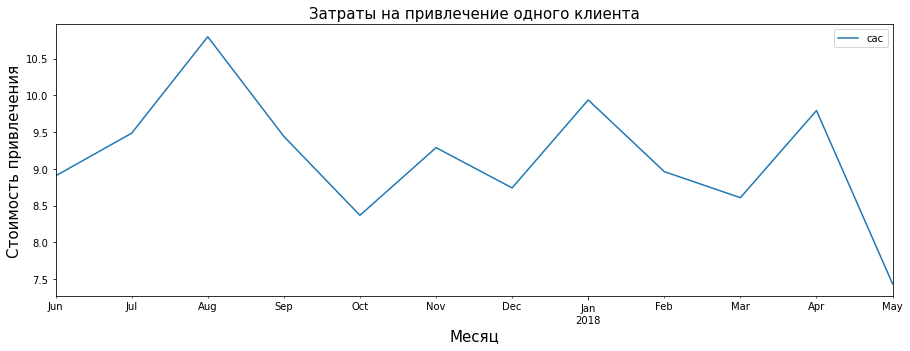

In [28]:
all_costs_month = costs.groupby('month').agg({'costs': 'sum'})
all_costs_month = all_costs_month.merge(customers_count, on = 'month')
all_costs_month['cac'] = all_costs_month['costs'] / all_costs_month['customers_count']

all_costs_month.plot(x = 'month', y = 'cac', figsize = (15, 5)) 
plt.title('Затраты на привлечение одного клиента', fontsize = 15);
plt.xlabel('Месяц', fontsize = 15);
plt.ylabel('Стоимость привлечения', fontsize = 15);

print('В среднем на привлечение одного покупателя расходуется {:.2f} у.е'.format(all_costs_month['cac'].mean()))

all_costs_month

In [29]:
#Удаляю данные из 7-го источника, так как я узнал, что там всего один пользователь
visits = visits[visits['source_id'] != 7]

In [30]:
# Считаю сумму расходов по каждому источнику
costs_by_source = costs.groupby('source_id').agg({'costs': 'sum'})
costs_by_source

,costs
source_id,
1,20833.27
2,42806.04
3,141321.63
4,61073.60
5,51757.10
9,5517.49
10,5822.49


In [31]:
# Создаю таблицу, в которой будут храниться номера пользователей и источник, из которого они пришли
source_by_user = visits.groupby('uid').agg({'source_id': 'first'})
source_by_user

,source_id
uid,
11863502262781,3
49537067089222,2
297729379853735,3
313578113262317,2
325320750514679,5
...,...
18446403737806311543,5
18446424184725333426,4
18446556406699109058,3


In [32]:
#Объединяю полученную таблицу с orders, группирую данные по источнику данных, суммирую значение доходов по каждому источнику
source_by_user_orders = (orders[['uid', 'revenue']].merge(source_by_user, on = 'uid').groupby('source_id')
                         .agg({'revenue': 'sum', 'uid': 'nunique'})
                         .rename(columns={'uid': 'users'})
                         .join(costs_by_source))
source_by_user_orders

,revenue,users,costs
source_id,,,
1,38560.06,3743,20833.27
2,65152.26,4323,42806.04
3,44317.68,9138,141321.63
4,52476.33,9822,61073.60
5,40357.91,6839,51757.10
9,7076.98,1415,5517.49
10,4111.34,1241,5822.49


In [33]:
# Считаю затраты на одного пользователя
source_by_user_orders['cac'] = source_by_user_orders['costs'] / source_by_user_orders['users']
source_by_user_orders

,revenue,users,costs,cac
source_id,,,,
1,38560.06,3743,20833.27,5.565928
2,65152.26,4323,42806.04,9.901929
3,44317.68,9138,141321.63,15.465269
4,52476.33,9822,61073.60,6.218041
5,40357.91,6839,51757.10,7.567934
9,7076.98,1415,5517.49,3.899286
10,4111.34,1241,5822.49,4.691773


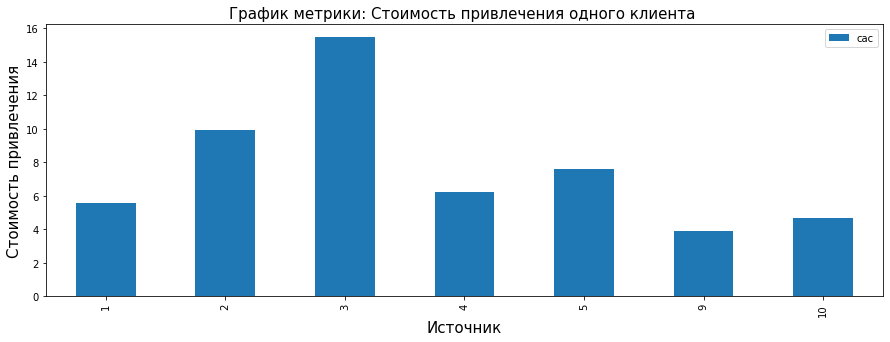

,revenue,users,costs,cac
source_id,,,,
1,38560.06,3743,20833.27,5.565928
2,65152.26,4323,42806.04,9.901929
3,44317.68,9138,141321.63,15.465269
4,52476.33,9822,61073.60,6.218041
5,40357.91,6839,51757.10,7.567934
9,7076.98,1415,5517.49,3.899286
10,4111.34,1241,5822.49,4.691773


In [34]:
# Cтрою график
source_by_user_orders.plot(kind='bar', y='cac', figsize=(15,5));
plt.title('График метрики: {} '.format('Стоимость привлечения одного клиента'), fontsize = 15);
plt.xlabel('Источник', fontsize = 15);
plt.ylabel('Стоимость привлечения', fontsize = 15);
plt.show()
source_by_user_orders

##### Выводы:
- В среднем на привлечение одного покупателя расходуется 9.15 у.е;
- Дороже всего обходится привлечение клиентов из 3-го источника;
- В августе самые большие затраты, в мае самые маленькие.

#### Рассчитайте ROMI по когортам в разрезе источников. Сравните окупаемость за одинаковые периоды жизни когорт. 

Предлагаю создать таблицу со всеми ROMI

In [35]:
source_by_user_orders

,revenue,users,costs,cac
source_id,,,,
1,38560.06,3743,20833.27,5.565928
2,65152.26,4323,42806.04,9.901929
3,44317.68,9138,141321.63,15.465269
4,52476.33,9822,61073.60,6.218041
5,40357.91,6839,51757.10,7.567934
9,7076.98,1415,5517.49,3.899286
10,4111.34,1241,5822.49,4.691773


In [36]:
source_by_user

,source_id
uid,
11863502262781,3
49537067089222,2
297729379853735,3
313578113262317,2
325320750514679,5
...,...
18446403737806311543,5
18446424184725333426,4
18446556406699109058,3


In [37]:
orders.head()

,date,revenue,uid,first_activity_date,first_orders_date,first_orders_month,month,orders_cohort_lifetime,passed_days
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01 00:10:00,2017-06-01,2017-06-01,0,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01 00:25:00,2017-06-01,2017-06-01,0,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01 00:27:00,2017-06-01,2017-06-01,0,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01 00:29:00,2017-06-01,2017-06-01,0,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01 07:58:00,2017-06-01,2017-06-01,0,0


In [38]:
# Создаю таблицу со всеми Ltv для каждого источника
ltv = (orders[['uid', 'revenue', 'orders_cohort_lifetime']]
    .merge(source_by_user, on='uid')
    .pivot_table(
         index='source_id', 
         columns='orders_cohort_lifetime', 
         values='revenue', 
         aggfunc='sum')
    .fillna(0)
    .cumsum(axis=1)
    .div(source_by_user_orders['users'], axis = 0)
)
ltv

orders_cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
source_id,,,,,,,,,,,,
1,5.990644,7.006548,7.706131,8.289182,8.638245,8.924384,9.437833,9.678274,9.868520,10.070232,10.272348,10.301913
2,6.356748,7.634284,8.946373,12.548904,13.280465,14.070155,14.463382,14.702033,14.852406,14.936461,15.008119,15.071076
3,4.369432,4.535156,4.608563,4.689781,4.743071,4.766994,4.810420,4.826284,4.833088,4.841279,4.846145,4.849823
4,4.637299,4.809582,4.922283,5.029248,5.111857,5.171983,5.213623,5.264406,5.293676,5.313608,5.337070,5.342734
5,4.751171,4.974887,5.235204,5.386732,5.538435,5.636021,5.720333,5.785015,5.837538,5.879278,5.894331,5.901142
9,3.840304,4.119710,4.322057,4.481527,4.577958,4.648396,4.698113,4.768113,4.929025,4.993717,5.001399,5.001399
10,3.121612,3.185431,3.225375,3.255898,3.274206,3.281749,3.294593,3.307510,3.312135,3.312135,3.312135,3.312925


In [39]:
# Считаю ROMI
romi = ltv.div(source_by_user_orders['cac'], axis = 0)
romi

orders_cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
source_id,,,,,,,,,,,,
1,1.076306,1.258828,1.384519,1.489272,1.551986,1.603395,1.695644,1.738843,1.773023,1.809264,1.845577,1.850889
2,0.641971,0.770990,0.903498,1.267319,1.341200,1.420951,1.460663,1.484765,1.499951,1.508439,1.515676,1.522034
3,0.282532,0.293248,0.297994,0.303246,0.306692,0.308239,0.311047,0.312072,0.312512,0.313042,0.313357,0.313594
4,0.745781,0.773488,0.791613,0.808815,0.822101,0.831771,0.838467,0.846634,0.851341,0.854547,0.858320,0.859231
5,0.627803,0.657364,0.691761,0.711784,0.731829,0.744724,0.755865,0.764411,0.771352,0.776867,0.778856,0.779756
9,0.984874,1.056529,1.108422,1.149320,1.174050,1.192115,1.204865,1.222817,1.264084,1.280675,1.282645,1.282645
10,0.665337,0.678940,0.687453,0.693959,0.697861,0.699469,0.702206,0.704960,0.705945,0.705945,0.705945,0.706114


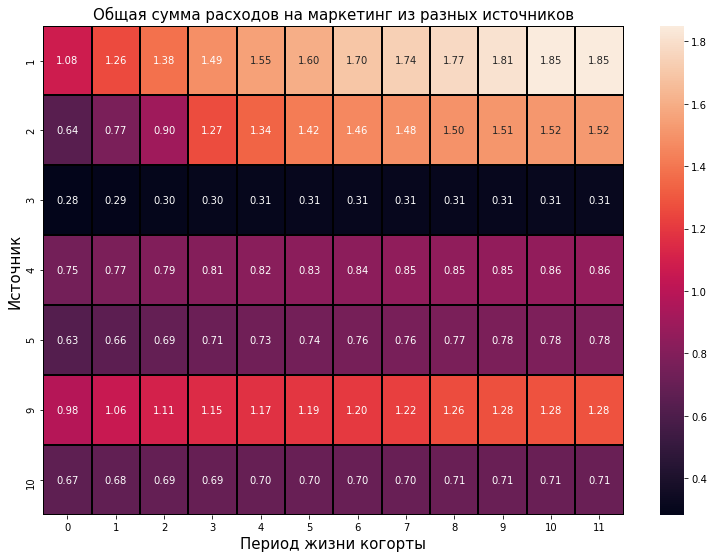

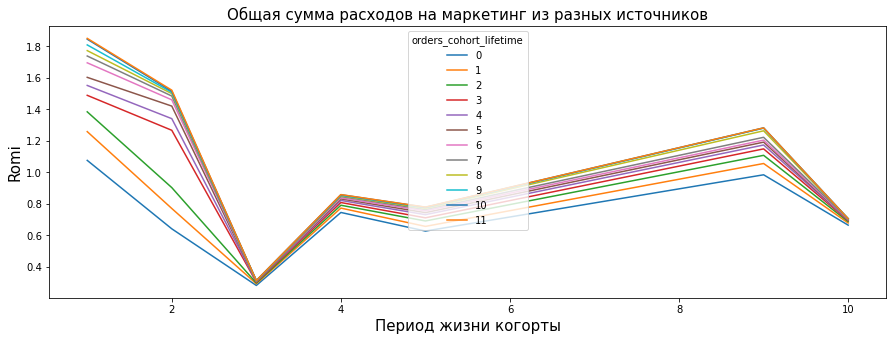

In [40]:
plt.figure(figsize=(13, 9))
plt.title('Общая сумма расходов на маркетинг из разных источников', fontsize = 15)
sns.heatmap(romi , annot=True, fmt='.2f', linewidths=1, linecolor='black')#, vmin=1, vmax=2.2, center= 0)
plt.xlabel('Период жизни когорты', fontsize = 15);
plt.ylabel('Источник', fontsize = 15);
plt.show()

romi.plot(figsize=(15,5));
plt.title(('Общая сумма расходов на маркетинг из разных источников'), fontsize = 15);
plt.xlabel('Период жизни когорты', fontsize = 15);
plt.ylabel('Romi', fontsize = 15);
plt.show()

##### Выводы:
- На протяжении большей части периодов жизни когорт источники номер 3 и 10 являются наименее прибыльными, при этом источник номер 3 расходует большую часть бюджета;
- На протяжении большей части периодов жизни когорт источники номер 1, 2 и 9 являются наиболее прибыльными, при этом источник номер 1 является таковым с первого месяца;
- На протяжении большей части периодов жизни когорт источники номер 4, 5 и 10 так и не стали прибыльными, более того - в последние 3 месяца их рост прекратился.

#### Общие выводы:
- Больше всего денег уходит на 3-й источник - более 40%;
- Столько же уходит на источники 2, 4 и 5;
- Источники 1, 9 и 10 вместе потребляют меньше, чем второй источник, а тот в 3 раза меньше, чем 3-й;
- С августа по март на 3-й источник было потрачено рекордное количество средств, при этом на источники 2,4 и 5 в это же время тоже тратится больше; 
- Общий пик затрат на почти все источники приходится на ноябрь-декабрь 2017;

Расходы:
- Общая сумма расходов на маркетинг из 1 источника: 20833.27 у.е
- Средняя сумма расходов на маркетинг из 1 источника: 1736.11 у.е
- Общая сумма расходов на маркетинг из 2 источника: 42806.04 у.е
- Средняя сумма расходов на маркетинг из 2 источника: 3567.17 у.е
- Общая сумма расходов на маркетинг из 3 источника: 141321.63 у.е
- Средняя сумма расходов на маркетинг из 3 источника: 11776.80 у.е
- Общая сумма расходов на маркетинг из 4 источника: 61073.60 у.е
- Средняя сумма расходов на маркетинг из 4 источника: 5089.47 у.е
- Общая сумма расходов на маркетинг из 5 источника: 51757.10 у.е
- Средняя сумма расходов на маркетинг из 5 источника: 4313.09 у.е
- Общая сумма расходов на маркетинг из 9 источника: 5517.49 у.е
- Средняя сумма расходов на маркетинг из 9 источника: 459.79 у.е
- Общая сумма расходов на маркетинг из 10 источника: 5822.49 у.е
- Средняя сумма расходов на маркетинг из 10 источника: 485.21 у.е


- В среднем на привлечение одного покупателя расходуется 9.15 у.е;
- На протяжении большей части периодов жизни когорт источники номер 3 и 10 являются наименее прибыльными, при этом источник номер 3 расходует большую часть бюджета;
- На протяжении большей части периодов жизни когорт источники номер 1, 2 и 9 являются наиболее прибыльными, при этом источник номер 1 является таковым с первого месяца;
- На протяжении большей части периодов жизни когорт источники номер 4, 5 и 10 так и не стали прибыльными, более того - в последние 3 месяца их рост прекратился.

## Сформулируйте выводы и рекомендации

### Определите источники трафика, на которые маркетологам стоит делать упор. Объясните свой выбор: на какие метрики вы ориентируетесь и почему;

- Стоит обратить пристальное внимение на источники 1, 2 и 9 - они довольно быстро начали приносить доход;
- Я бы порекомендовал обратить особое внимение на источники трафика 4 и 5 - показатели Romi говорят, что они приблизились к порогу окупаимости.
- Маркетинговый бюджет на источник 3 следует уменьшить, так как у него самая низкая маржинальность, а затраты в пересчете на одного пользователя при этом самые высокие.

### Опишите выводы, которые вы сделали после подсчёта метрик каждого вида.

Продуктовые метрики:
- Средние значения метрики DAU за всё время: 908 
- Средние значения метрики WAU за всё время: 5716 
- Средние значения метрики MAU за всё время: 23228
- В среднем на сайт заходят один раз в день, чуть больше 8% пользователей делают это больше раз;
- В новый год этот показатель увеличивается до 22%, в начале апреля просаживается до единицы;
- Средняя продолжительность пользовательской сессии на ПК - 11.7 минут, медианная - 6 минут;
- Средняя продолжительность пользовательской сессии на смартфоне - 8 минут, медианная - 3 минут;
- Средняя продолжительность пользовательской сессии на всех устройствах - 10.7 минут, медианная - 5 минут;
- Среднее значение Ratention Rate для второй когорты 6.52%;
- В целом наблюдаются довольно слабые показатели по возвратам.

Метрики электронной коммерции:
- Большинство людей производят покупку в течении первых 4-х дней (75%), в половине случаев это происходит в первый день;
- Среднее количество покупок на одного покупателя за 6 месяцев: 1.43;
- Среднее количество покупок на одного покупателя за всё время: 2.19;
- Средний чек на одного пользователя составляет 3 у.е;
- Люди, которые впервые пришли в августе, принесли больше всего денег, особенно хорошо это проявляется ближе к Новому Году;
- Средний LTV по когортам за 6 месяцев: 7.97 у.е
- Средний LTV по когортам за всё время: 11.88 у.е
- Когорты, прожившие более 6 месяцев, приносят от 6 у.е до 13.5 у.е;

Маркетинговые метрики:
- Больше всего денег уходит на 3-й источник - более 40%;
- Столько же уходит на источники 2, 4 и 5;
- Источники 1, 9 и 10 вместе потребляют меньше, чем второй источник, а тот в 3 раза меньше, чем 3-й;
- С августа по март на 3-й источник было потрачено рекордное количество средств, при этом на источники 2,4 и 5 в это же время тоже тратится больше; 
- Общий пик затрат на почти все источники приходится на ноябрь-декабрь 2017;

Расходы:
- Общая сумма расходов на маркетинг из 1 источника: 20833.27 у.е
- Средняя сумма расходов на маркетинг из 1 источника: 1736.11 у.е
- Общая сумма расходов на маркетинг из 2 источника: 42806.04 у.е
- Средняя сумма расходов на маркетинг из 2 источника: 3567.17 у.е
- Общая сумма расходов на маркетинг из 3 источника: 141321.63 у.е
- Средняя сумма расходов на маркетинг из 3 источника: 11776.80 у.е
- Общая сумма расходов на маркетинг из 4 источника: 61073.60 у.е
- Средняя сумма расходов на маркетинг из 4 источника: 5089.47 у.е
- Общая сумма расходов на маркетинг из 5 источника: 51757.10 у.е
- Средняя сумма расходов на маркетинг из 5 источника: 4313.09 у.е
- Общая сумма расходов на маркетинг из 9 источника: 5517.49 у.е
- Средняя сумма расходов на маркетинг из 9 источника: 459.79 у.е
- Общая сумма расходов на маркетинг из 10 источника: 5822.49 у.е
- Средняя сумма расходов на маркетинг из 10 источника: 485.21 у.е


- В среднем на привлечение одного покупателя расходуется 9.15;
- Самые высокие показатели Romi у источников 1, 2 и 9, первый источник выделяется сильнее всего;
- Самые низкие показатели Romi у источников 3 и 10, третий источник самый провальный;

### Подведите итоги когортного анализа. Определите самые перспективные для компании когорты клиентов;

- Retention_rate у всех когорт довольно низкий, нужно над этим поработать;
- Чтобы увеличить прибыль, нужно отказаться от денежных вливаний в 3-й источник и сфокусироваться на источниках 1, 2 и 9;
- Стоит попробовать убеждать людей заходить на сайт через ПК, так как в таком случае они будут проводить на нём больше времени;
- Нужно подумать, как увеличить среднее количество покупок на одного пользователя.

## Чек-лист готовности проекта

Шаг 1. Загрузите данные и подготовьте их к анализу
- [x]  Положите данные о визитах, заказах и рекламных расходах в переменные;
- [x]  Подготовьте данные. Убедитесь, что тип данных во всех колонках соответствует сохранённым в них значениям.

Шаг 2. Рассчитайте метрики и постройте графики
Посчитайте метрики трёх видов:
- [x]  продуктовые,
- [x]  метрики электронной коммерции,
- [x]  маркетинговые.
- [x]  Отобразите на графиках изменения каждой метрики во времени. 
- [x]  После каждого пункта сформулируйте выводы.

Продуктовые метрики
- [x]  Рассчитайте DAU, WAU и MAU. Вычислите средние значения этих метрик за весь период. Отобразите изменения метрик во времени на графиках;
- [x]  Определите, сколько раз за день пользователи в среднем заходят на сайт. Постройте график, отражающий изменения метрики во времени;
- [x]  Исследуйте, сколько времени пользователи проводят на сайте. Узнайте продолжительность типичной пользовательской сессии за весь период. Чтобы выбрать подходящую среднюю меру, постройте график распределения. Изменение продолжительности сессий во времени изучать необязательно;
- [x]  Рассчитайте Retention Rate, применяя когортный анализ. Покажите изменения метрики во времени на графике. Найдите средний Retention Rate на второй месяц «жизни» когорт.

Метрики электронной коммерции
- [x]  Исследуйте, сколько времени в среднем проходит с момента первого посещения сайта до совершения покупки. Изучать изменение этой метрики во времени необязательно;
- [x]  Применяя когортный анализ или другой метод, рассчитайте среднее количество покупок на одного покупателя за определённый период, например за 6 месяцев. Изучать изменение этой метрики во времени необязательно;
- [x]  Рассчитайте средний чек, применяя группировку по времени совершения покупки. Когортный анализ не подходит — он может исказить расчёты. Постройте график, отражающий изменения метрики во времени;
- [x]  Выясните, как меняется LTV на покупателя по когортам. Помните, что LTV — накопительная метрика. Рассчитайте средний LTV по когортам за 6 месяцев; в расчёт включайте когорты, «прожившие» не менее 6 месяцев. Маржинальность сервиса — 100%. Отразите изменения метрики во времени на графике;

Маркетинговые метрики
- [x]  Посчитайте общую сумму расходов на маркетинг. Выясните, как траты распределены по источникам. Визуализируйте изменения метрик во времени;
- [x]  Рассчитайте средний CAC на одного покупателя для всего проекта и для каждого источника трафика. Отразите изменения метрик на графиках;
- [x]  Рассчитайте ROMI по когортам в разрезе источников. Сравните окупаемость за одинаковые периоды жизни когорт. Обратите внимание, что клиенты, пришедшие из разных источников, могут иметь разный LTV. Постройте графики, отражающие изменения метрик во времени.

Шаг 3. Сформулируйте выводы и рекомендации
- [x]  Определите источники трафика, на которые маркетологам стоит делать упор. Объясните свой выбор: на какие метрики вы ориентируетесь и почему;
- [x]  Опишите выводы, которые вы сделали после подсчёта метрик каждого вида: маркетинговых, продуктовых и метрик электронной коммерции;
- [x]  Подведите итоги когортного анализа. Определите самые перспективные для компании когорты клиентов;